In [2]:
# test if pytorch can run in gpu
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")
if cuda_available:
    print(f"CUDA device count: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"CUDA device {i}: {torch.cuda.get_device_name(i)}")

print(torch.__version__)
print(torch.version.cuda)

CUDA available: True
CUDA device count: 1
CUDA device 0: NVIDIA GeForce RTX 4080
cuda
2.4.1+cu118
11.8


### Understand data

In [6]:
from PIL import Image
import numpy as np

image = Image.open('data/train/54.jpg')
pic = np.array(image)

print(pic.shape)

(224, 224, 3)


In [29]:
# read metadata
import pandas as pd
metadata = pd.read_csv('data/train.csv')

# check the values in stable_height
print(metadata['stable_height'].value_counts())

stable_height
2    1920
1    1920
3    1536
4    1152
5     768
6     384
Name: count, dtype: int64


### Test model accuracy

In [1]:
import torch
from torch.utils.data import DataLoader
from backbones.pretrained_inceptionv4 import CNN
import dataset
import os

d:\Miniconda\envs\CV\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Load the test dataset
def load_test_data(csv_file, image_dir, batch_size=64):
    test_dataset = dataset.StackDataset(csv_file=csv_file, image_dir=image_dir, img_size=224, stable_height = 'stable_height', train=False, testMode=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    return test_loader

In [6]:
# Function to calculate accuracy for classification model output
def calculate_accuracy(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, targets, ids in test_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)
            targets = targets.long()  # Ensure targets are long for classification
            
            # Get model predictions (outputs are logits)
            outputs = model(inputs)
            
            # Get the index of the max logit (predicted class for each sample)
            _, predicted = torch.max(outputs, 1)  # outputs shape: [batch_size, n_classes]
            predicted = predicted.long() + 1  # Convert to original class labels

            # write the results to a csv file
            with open('predict_results/predict_results.csv', 'a') as f:
                # add header
                if os.stat('predict_results/predict_results.csv').st_size == 0:
                    f.write("id,stable_height\n")
                for i in range(len(ids)):
                    f.write(f"{ids[i]},{predicted[i].item()}\n")
            
            # Update accuracy metrics
            total += targets.size(0)
            correct += (predicted == targets).sum().item()  # Compare predicted+1 and actual targets
            
    if total == 0:  # Prevent division by zero
        return 0
    accuracy = 100 * correct / total
    return accuracy

In [7]:
# Function to test model accuracy
def test_model_accuracy(model_path, csv_file, image_dir):
    # Load the model
    model = CNN()  # Initialize model
    model.load_state_dict(torch.load(model_path, weights_only=True))  # Load saved weights
    model.to(device)  # Move model to the device

    # Load the test data
    test_loader = load_test_data(csv_file, image_dir)
    
    # Calculate accuracy
    accuracy = calculate_accuracy(model, test_loader, device)
    print(f"Model Accuracy on Test Set: {accuracy:.2f}%")
    return accuracy

In [ ]:
csv_file='data/sample-solution.csv'
image_dir='data/test'
model_path_root='models/exp6(resnet7_99train1val_base_exp5)'

# import re
# def natural_sort_key(s):
#     return [int(text) if text.isdigit() else text for text in re.split(r'(\d+)', s)]

# # loop through all models and print accuracy
# for model_file in sorted(os.listdir(model_path_root), key=natural_sort_key):
#     model_path = os.path.join(model_path_root, model_file)
#     print(f"Testing model: {model_path}")
#     test_model_accuracy(model_path, csv_file, image_dir)

test_model_accuracy(model_path_root + '/model_epoch_20.pth', csv_file, image_dir)

In [4]:
# Function to generate predictions and save to CSV
def generate_predictions(model, test_loader, device):
    model.eval() 
    with torch.no_grad(): 
        output_dir = 'predict_results'
        os.makedirs(output_dir, exist_ok=True)
        output_file = os.path.join(output_dir, 'predict_results.csv')
        
        with open(output_file, 'w') as f:
            f.write("id,stable_height\n")
            for inputs, ids in test_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                
                out_main = outputs[0]

                # for classification models
                _, predicted_height = torch.max(out_main, 1)
                predicted_height = predicted_height.cpu().numpy().astype(int)
                predicted_height = predicted_height + 1  # Convert to original class labels
                
                # # for regression models
                # predicted_height = torch.round(out_main.squeeze())
                # predicted_height = torch.clamp(predicted_height, min=1, max=6)
                # predicted_height = predicted_height.cpu().numpy().astype(int)
                
                ids = ids.numpy().astype(int)
                
                for i in range(len(ids)):
                    f.write(f"{ids[i]},{predicted_height[i]}\n")
    print(f"Predictions saved to {output_file}")

In [5]:
image_dir='data/test'
csv_file='data/sample-solution.csv'
model_path='models/exp12(add_total_height_T24_base_exp11)/model_epoch_24.pth'

# load test data
test_loader = load_test_data(csv_file, image_dir)

# load model
model = CNN()
model.load_state_dict(torch.load(model_path, weights_only=True))
model.to(device)

# get csv result
generate_predictions(model, test_loader, device)

Predictions saved to predict_results\predict_results.csv


### Visualization of results

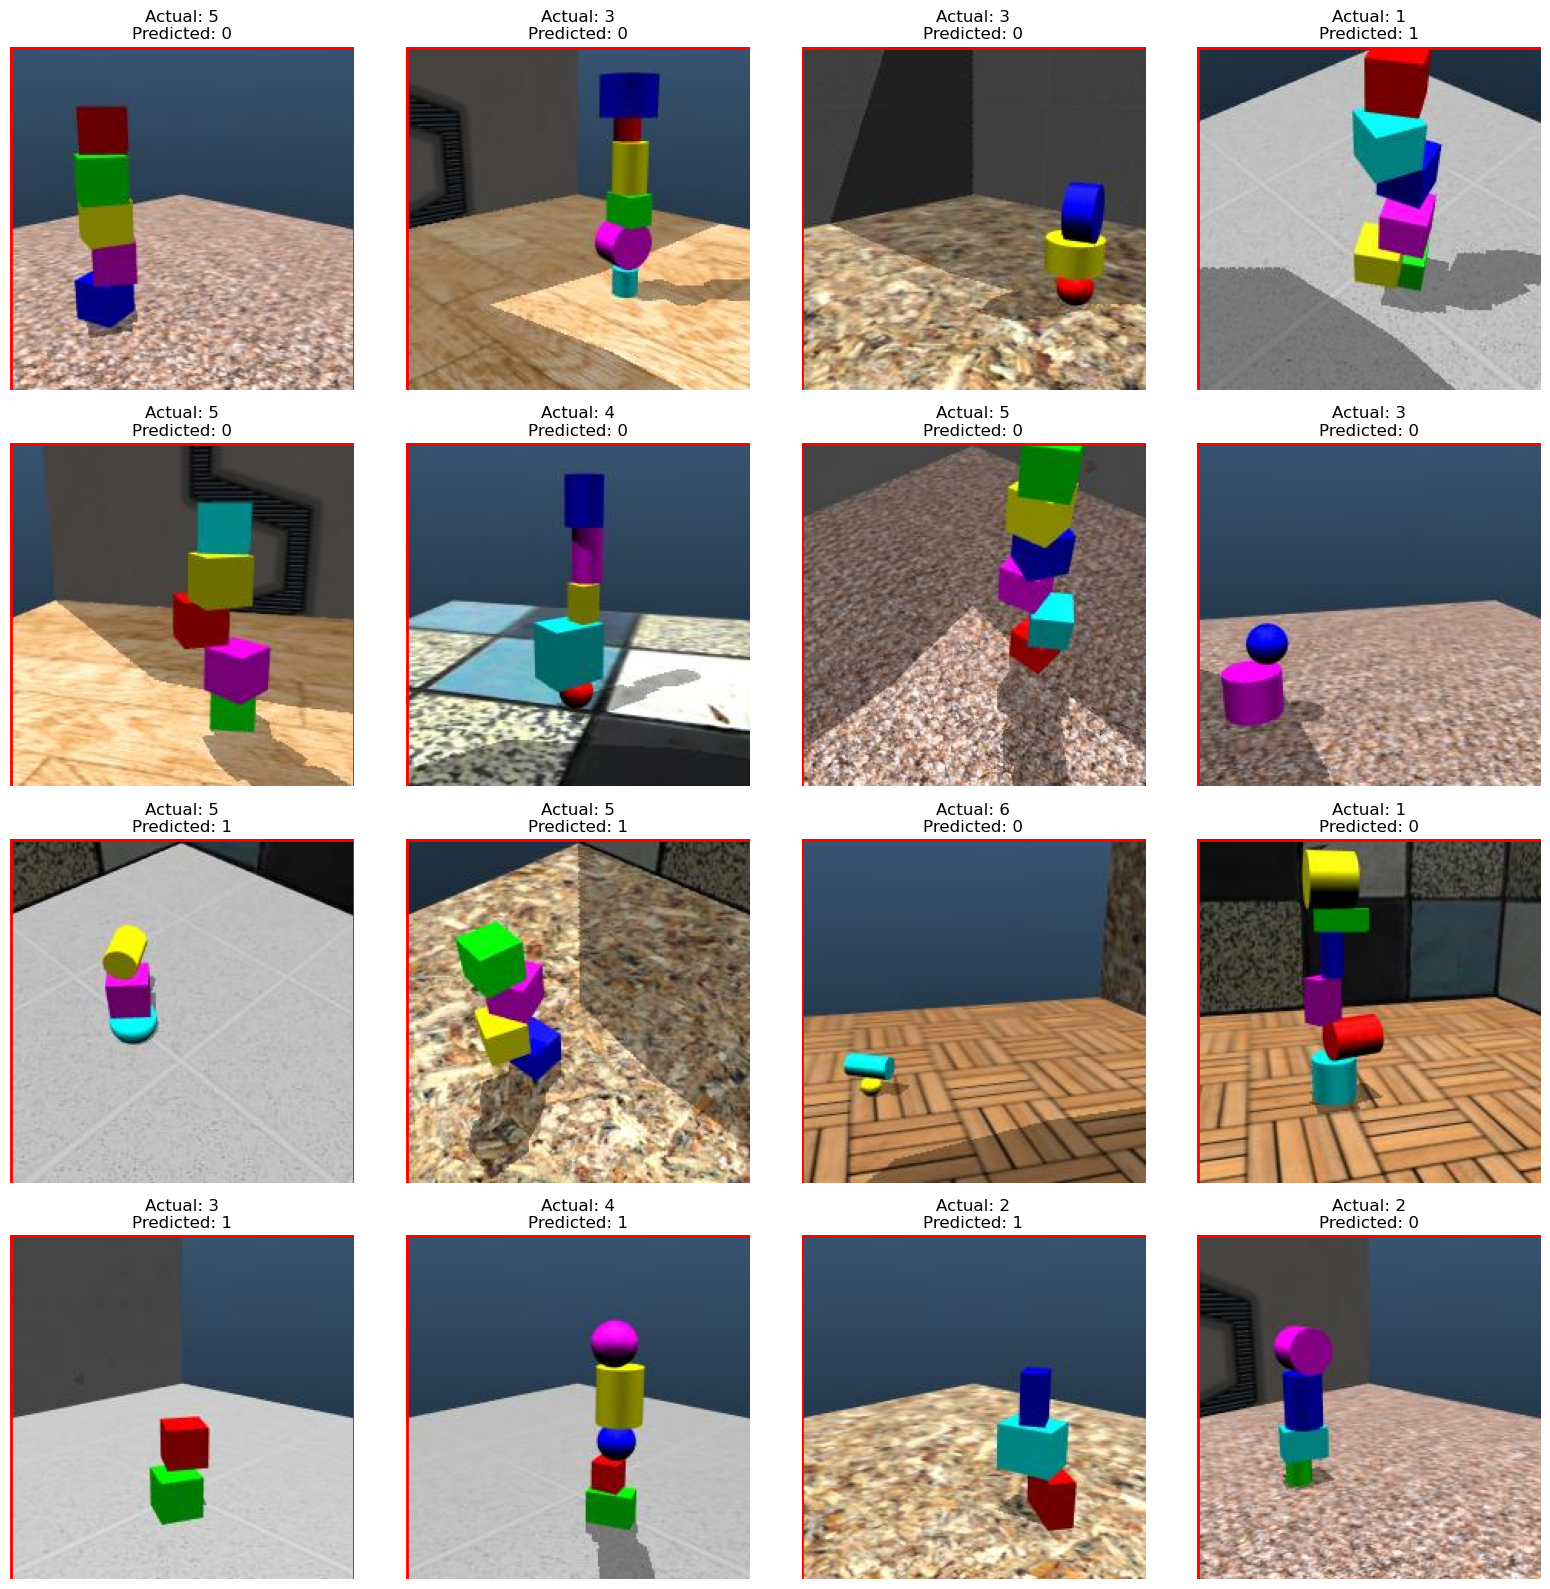

In [14]:
# visualize the predicted label together with the image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import numpy as np

def visualize_predictions(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, targets in test_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)
            targets = targets.long()  # Ensure targets are long for classification
            
            # Get model predictions (outputs are logits)
            outputs = model(inputs)
            
            # Get the index of the max logit (predicted class for each sample)
            _, predicted = torch.max(outputs, 1)  # outputs shape: [batch_size, n_classes]
            
            # Convert tensors to numpy arrays
            inputs = inputs.cpu().numpy()
            targets = targets.cpu().numpy()
            predicted = predicted.cpu().numpy()
            
            # Plot the images and labels
            fig, axes = plt.subplots(4, 4, figsize=(16, 16))
            for i, ax in enumerate(axes.flat):
                # Un-normalize the image
                img = inputs[i].transpose((1, 2, 0))
                img = (img * 255).astype(np.uint8)
                
                # Get the label
                target_label = targets[i]
                predicted_label = predicted[i]
                
                # Plot the image
                ax.imshow(img)
                
                # Set the title for the image
                ax.set_title(f"Actual: {target_label}\nPredicted: {predicted_label}")
                
                # Turn off axis lines and labels
                ax.axis('off')
                
                # Draw a rectangle around the predicted label
                rect = patches.Rectangle((0, 0), 224, 224, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                
            plt.tight_layout()
            plt.show()
            break  # Break after first batch

# Load the test data
test_loader = load_test_data(csv_file, image_dir, batch_size=16)

# Load the model
from backbones.baseline_SE import CNN
model = CNN()  # Initialize model
model.load_state_dict(torch.load(model_path, weights_only=True))  # Load saved weights
model.to(device)  # Move model to the device

# Visualize predictions
visualize_predictions(model, test_loader, device)